In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from deepseries.models import WaveNet
from deepseries.dataset import Property, TimeSeries, Seq2SeqDataLoader
from deepseries.nn.loss import MSELoss, RMSELoss
from deepseries.train import Learner
from deepseries.optim import ReduceCosineAnnealingLR
from torch.optim import Adam
from torch import nn
import matplotlib as mpl

C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Text(0.5, 1.0, ' log sin curve with noisy')

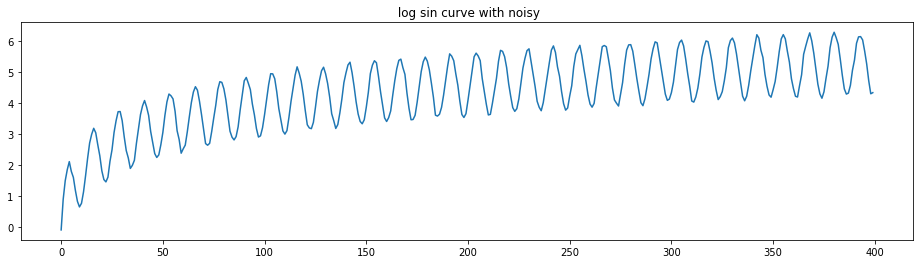

In [2]:
x = np.arange(0, 200, 0.5)
log_sin = np.sin(x) + np.log1p(x) + np.random.normal(0, 0.05, len(x))
plt.figure(figsize=(16, 4))
plt.plot(log_sin)
plt.title(" log sin curve with noisy")

In [3]:
# normalize
test_size = 1
valid_size = 50

mu = log_sin[:-200].mean()
std = log_sin[:-200].std()

log_sin = (log_sin - mu) / std

# reshape series shape (n_series, series_len, series_dim)
log_sin = log_sin.reshape(1, -1, 1)

# cut for train / test / valid

enc_len = 100
dec_len = 100

class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        size = time_idx - enc_len - dec_len + 1
        if valid_size < 1:
            valid_size = int(np.floor(size * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len+dec_len-1):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()
train_idx, valid_idx = spliter.split(np.arange(len(x)), enc_len, dec_len, test_size+valid_size)
valid_idx, test_idx = spliter.split(valid_idx, enc_len, dec_len, test_size)

train_xy = TimeSeries(log_sin[:, train_idx])
valid_xy = TimeSeries(log_sin[:, valid_idx])
test_xy = TimeSeries(log_sin[:, test_idx])

In [4]:
# build data lodaer

train_dl = Seq2SeqDataLoader(train_xy, 32, enc_len, dec_len, use_cuda=True, time_free_space=10, mode='train', seq_last=False)
valid_dl = Seq2SeqDataLoader(valid_xy, 32, enc_len, dec_len, use_cuda=True, time_free_space=0, mode='valid', seq_last=False)
test_dl = Seq2SeqDataLoader(test_xy, 32, enc_len, dec_len, use_cuda=True, mode='eval', seq_last=False)

In [ ]:
# build model and learner

model = WaveNet(dropout=0, )
opt = Adam(model.parameters(), 0.001)
loss_fn = MSELoss()
model.cuda()
lr_scheduler = ReduceCosineAnnealingLR(opt, 64)
learner = Learner(model, opt, loss_fn, './test', verbose=5000, lr_scheduler=None)
learner.fit(200, train_dl, valid_dl, patient=64, start_save=1, early_stopping=True)